In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head(3)

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34250 entries, 0 to 34249
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   posting_id   34250 non-null  object
 1   image        34250 non-null  object
 2   image_phash  34250 non-null  object
 3   title        34250 non-null  object
 4   label_group  34250 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.3+ MB


In [5]:
df.duplicated().sum()

0

In [6]:
df.nunique()

posting_id     34250
image          32412
image_phash    28735
title          33117
label_group    11014
dtype: int64

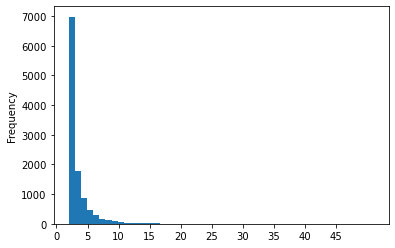

In [7]:
df.label_group.value_counts().plot.hist(bins=50)
plt.xticks(range(0,50,5));

#### Train Test Split

In [8]:
# Train Test Split

from sklearn.utils import shuffle

def split_data_by_group(df, features, target, id_to_split, train_size):
    """ returns train and test set divided by group 
    """
    
    df = shuffle(df)
    cum_sum = pd.DataFrame(df[id_to_split].value_counts().cumsum()/\
                           len(df))

    train_indexes = cum_sum[cum_sum[id_to_split] <= train_size].index.values
    test_indexes = cum_sum[cum_sum[id_to_split] > train_size].index.values

    X_train = df.loc[df[id_to_split].isin(train_indexes), features]
    X_test = df.loc[df[id_to_split].isin(test_indexes), features]

    y_train = df.loc[df[id_to_split].isin(train_indexes), target]
    y_test = df.loc[df[id_to_split].isin(test_indexes), target]
    
    return X_train, X_test, y_train, y_test

In [9]:
# train test split

id_to_split = 'label_group'
train_val_size = 0.8
train_size = 0.96
features = ['title', 'label_group']
id_to_split = 'label_group'
target = 'label_group'

# train-test split
X_train, X_test, y_train, y_test = split_data_by_group(df, features, target, id_to_split, train_val_size)

# train-validation split
X_train, X_val, y_train, y_val = split_data_by_group(X_train, features, target, id_to_split, train_size)


In [10]:
features = ['title']

In [11]:
# X_train = X_train['title']
# X_val = X_val['title']
# X_test = X_test['title']

In [12]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape,  X_test.shape, y_test.shape

((26304, 2), (1096, 2), (26304,), (1096,), (6850, 2), (6850,))

#### Preprocessing

In [13]:
# lowering and removing punctuations
import string

X_train['title'] = X_train['title'].replace(string.punctuation, '').str.lower()
X_val['title'] = X_val['title'].replace(string.punctuation, '').str.lower()
X_test['title'] = X_test['title'].replace(string.punctuation, '').str.lower()

#### Similarity

In [14]:
from difflib import SequenceMatcher

In [15]:
def similar(s1, s2):
    return SequenceMatcher(None, s1, s2).ratio()

In [16]:
same_similarity = []

gby_label = X_train.groupby('label_group')

for g in tqdm(gby_label):
    group_df = g[1]
    for i in range(len(group_df) - 1):
        for j in range(i + 1, len(group_df)):
            sim = similar(group_df.iloc[i, 0], group_df.iloc[j, 0])
            same_similarity.append(sim)
            
same_similarity = pd.Series(same_similarity)

  0%|          | 0/7041 [00:00<?, ?it/s]

In [17]:
diff_similarity = []

for i in tqdm(range(len(X_train))):
    j = np.random.randint(0, len(X_train))
    if y_train.iloc[i] != y_train.iloc[j]:
        sim = similar(X_train.iloc[i, 0], X_train.iloc[j, 0])
        diff_similarity.append(sim)

diff_similarity = pd.Series(diff_similarity)

  0%|          | 0/26304 [00:00<?, ?it/s]

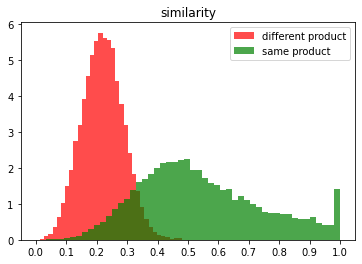

In [18]:
plt.hist(diff_similarity, density=True, bins = 50, color = 'r', alpha=0.7, label='different product')
plt.hist(same_similarity, density=True, bins = 50, color ='g', alpha=0.7, label='same product')

plt.legend()
plt.title('similarity')
plt.xticks(np.linspace(0,1,11));

#### Same product similarity stats

In [19]:
same_similarity.describe().round(2)

count    79778.00
mean         0.54
std          0.20
min          0.01
25%          0.39
50%          0.51
75%          0.67
max          1.00
dtype: float64

#### Different product similarity stats

In [20]:
diff_similarity.describe().round(2)

count    26299.00
mean         0.22
std          0.07
min          0.00
25%          0.17
50%          0.22
75%          0.27
max          0.69
dtype: float64

#### Choosing threshold:
- The data is very imblanced the proportion of same product to not same product is ~ 1 to 20k.
- We will choose a threshold that takes into consideration the prior probabilities.
- **calculate maximum likelihood**

In [21]:
diff_similarity.quantile(0.9999)

0.6086956521739131

#### Preparing True Matches (y_true)

In [22]:
# preparing true matches

def get_matches(y, grouped_data):
    """ returns list of all matches by item
    """
    
    matches = []
    for i in tqdm(range(len(y))):
        g = y.iloc[i]
        labels = list(grouped_data.get_group(g).index)
        matches.append(labels)
    
    return matches

In [23]:
grouped_train = X_train.groupby('label_group')
grouped_val = X_val.groupby('label_group')
grouped_test = X_test.groupby('label_group')

matches_train = get_matches(y_train, grouped_train)
matches_val = get_matches(y_val, grouped_val)
matches_test = get_matches(y_test, grouped_test)

  0%|          | 0/26304 [00:00<?, ?it/s]

  0%|          | 0/1096 [00:00<?, ?it/s]

  0%|          | 0/6850 [00:00<?, ?it/s]

#### Predicting on validation

In [24]:
def get_predictions(X, thresh):
    """returns predictions for given data and threshold
    """
    
    idx = X.index
    
    pred = [[idx[i]] for i in range(len(X))]


    for i in tqdm(range(len(X))):
    
        for j in range(i + 1, len(X)):
            
            sim = similar(X.iloc[i,0], X.iloc[j,0])
            
            if sim >= thresh:
                pred[i].append(idx[j])
                pred[j].append(idx[i])
    
    return pred

In [25]:
thresholds = [0.5]
preds = []

for thresh in thresholds:
    pred = get_predictions(X_val, thresh)
    preds.append(pred)

  0%|          | 0/1096 [00:00<?, ?it/s]

In [26]:
def get_f1_score(pred, y_true):
    """returns mean F1 score. The mean is calculated in a sample-wise fashion, 
        meaning that an F1 score is calculated for every predicted row, then averaged.
    """
    
    f1_scores = []
    
    for i in range(len(pred)):
        
        p = pred[i]
        p_true = y_true[i]
        
        tp = len(set(p) & set(p_true)) - 1
        fp = len(np.setdiff1d(p, p_true))
        fn = len(np.setdiff1d(p_true, p))
        
        f1 = tp / (tp + 0.5*(fp + fn))
        
        f1_scores.append(f1)

    return sum(f1_scores) / len(f1_scores) , f1_scores
    

In [27]:
for pred in preds:
    mean_f1 , f1_scores = get_f1_score(pred, matches_val)
    print(mean_f1)

0.5888425443169968


In [29]:
# vectorizing

# from collections import Counter
# from sklearn.feature_extraction.text import CountVectorizer

# vectorizer = CountVectorizer(max_features=None, stop_words='english')
# X = vectorizer.fit_transform(X).toarray()

# same_label = []
# diff_label = []

# filt = X_train > 0
# labels = y_train.reset_index()['label_group']

# num_of_words = filt.sum(axis=1)

# for i in range(len(X_train) - 1):
#     for j in range(i + 1, len(X_train)):
        
#         c = (filt[i] & filt[j]).sum()
        
#         similarity = max(c / num_of_words[i], c / num_of_words[i])
        
#         if labels[i] == labels[j]:
#             same_label.append(similarity)
#         else:
#             diff_label.append(similarity)
    

In [45]:
all_words = []
for title in df['title']:
    title_words = title.lower().split(' ')
    for each_word in title_words:
        all_words.append(each_word)

In [46]:
word_counts = []
for word in all_words:
    word_counts.append((word, all_words.count(word)))

In [47]:
word_counts = list(set(word_counts))

In [48]:
len(word_counts)

33899

In [49]:
word_counts.sort(key = lambda x: x[1], reverse=True)

In [50]:
common_words = [word[0] for word in word_counts[:500]]

In [51]:
df2 = pd.DataFrame(columns=common_words)

In [52]:
df3 = pd.concat([df,df2], axis=1)

In [65]:
for word in common_words:
    for i, title in enumerate(df['title'][:5000]):
        if word in title:
            df3.loc[i, word] = 1
        else:
            df3.loc[i, word] = 0

In [66]:
df4 = df3[:5000]

In [67]:
df5 = df4.drop(['posting_id', 'image', 'image_phash', 'title'], axis=1)

In [68]:
df5.head()

,label_group,/,-,anak,wanita,,original,1,murah,tas,...,batam,teh,tv,tutup,you,big,halus,kuning,instant,hias
0,249114794,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2937985045,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2395904891,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4093212188,1,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3648931069,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
sum(y.value_counts()<2)

2979

In [75]:
df6 = df5.groupby('label_group').filter(lambda x: len(x) > 1)

In [76]:
X = df6.drop(['label_group'], axis=1)
y = df6['label_group']

In [79]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12)

In [169]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

rf_clf = RandomForestClassifier(random_state=0, n_estimators=150, max_depth=50)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

In [170]:
print('Accuracy of Random Forest classifier on training set: {:.2f}'
     .format(rf_clf.score(X_train, y_train)))
print()
print(f'Accuracy of Random Forest classifier on test set: {accuracy_score(y_test, y_pred):.2f}')

Accuracy of Random Forest classifier on training set: 0.88

Accuracy of Random Forest classifier on test set: 0.31
